# Mapillary label analysis

This notebook aims at describing the [Mapillary](https://www.mapillary.com/dataset/vistas) dataset. This dataset is used for semantic segmentation purpose, and contains 25000 street-scene images:
- 18000 in training dataset;
- 2000 in validation dataset;
- 5000 in testing dataset.

In the following cells, the dataset labels will be described, and their popularity within dataset will be evaluated. Additionnally, the following questions will be answered: what is the frequency of appearance of each object type? How many labels appear on a typical image? What are the most frequent object association?

## Introduction

As usual, we import the useful module. `pandas` is of course needed, as we will handle dataframes.

In [2]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

%matplotlib inline

Some modules in `./deeposlandia` are recovered to make the analysis easier.

In [3]:
from deeposlandia import aggregate_label, dataset, utils

In [4]:
DATAPATH = '../data'
DATASET = 'mapillary'

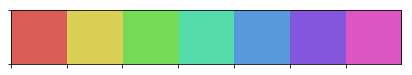

In [5]:
palette = sns.color_palette('hls', 7)
sns.palplot(palette)

## Metadata description

In [6]:
config = utils.read_config(os.path.join(DATAPATH, DATASET, "input", "config.json"))

In [7]:
labels = config["labels"]
labels[:2]

[{'color': [165, 42, 42],
  'instances': True,
  'readable': 'Bird',
  'name': 'animal--bird',
  'evaluate': True},
 {'color': [0, 192, 0],
  'instances': True,
  'readable': 'Ground Animal',
  'name': 'animal--ground-animal',
  'evaluate': True}]

In order to describe the Mapillary dataset labels, we transform the information contained into configuration file as a `pandas.DataFrame`.

In [8]:
df_labels = aggregate_label.config_as_dataframe(config)
df_labels.head(3)

,color,evaluate,instances,name,readable,id,family,label,new_label
0,"[165, 42, 42]",True,True,animal--bird,Bird,0,animal,bird,animal
1,"[0, 192, 0]",True,True,animal--ground-animal,Ground Animal,1,animal,ground-animal,animal
2,"[196, 196, 196]",True,False,construction--barrier--curb,Curb,2,construction,curb,barrier


In [9]:
len(df_labels)

66

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

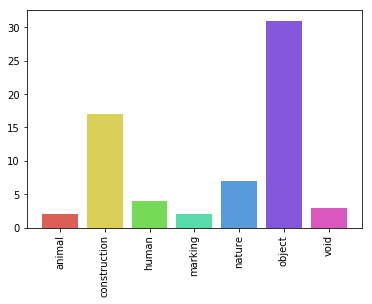

In [10]:
label_categories = df_labels['family'].unique()
plt.bar(label_categories, df_labels.groupby("family")['name'].count(), color=palette)
plt.xticks(rotation=90)

There is 66 labels, splitted into 7 subclasses: `animal`, `construction`, `human`, `marking`, `nature`, `object` and `void`. Whilst the `object` category contains a lot of labels, there are only a few ones for `animal`, `human`, `marking` or `void` categories.

The labels have two levels of subdivision, so we may create a shorter list of aggregated labels. We get the following new labels:

In [15]:
agg_label_family = (df_labels[["family", "new_label"]]
                    .copy()
                    .drop_duplicates()
                    .set_index('new_label'))
agg_label_family

,family
new_label,
animal,animal
barrier,construction
flat,construction
structure,construction
human,human
rider,human
marking,marking
nature,nature
object,object


They are 11 new labels that represented the Mapillary dataset in a more simplified way. `construction` is splitted into `barrier`, `flat` and `construction` labels, whilst `object` is splitted into ̀`object`, `traffic` and `vehicle` labels.

As a remark, we may note that `human` class contains `human` and `rider` sub-labels, however this case if not considered when aggregating labels as `rider` label is rare.

In [16]:
agg_color = []
for label in agg_label_family['family']:
    mask = label==df_labels['family'].unique()
    agg_color.append(palette[np.argmax(mask)])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

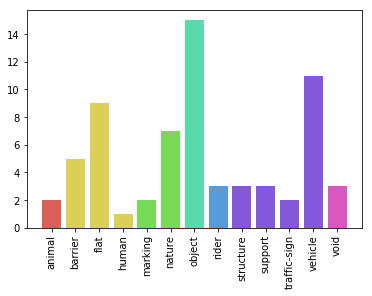

In [18]:
agg_label_count = df_labels.groupby('new_label')['name'].count()
plt.bar(agg_label_count.index, agg_label_count, color=agg_color)
plt.xticks(rotation=90)

These aggregation step makes a more balanced distribution. In particular, we denote:
- 16 miscellaneous `object` labels:

In [20]:
df_labels.loc[df_labels['new_label']=="object", "readable"].values

array(['Banner', 'Bench', 'Bike Rack', 'Billboard', 'Catch Basin',
       'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox',
       'Manhole', 'Phone Booth', 'Pothole', 'Street Light',
       'Traffic Light', 'Trash Can'], dtype=object)

- 11 `vehicle` objects:

In [21]:
df_labels.loc[df_labels['new_label']=="vehicle", "readable"].values

array(['Bicycle', 'Boat', 'Bus', 'Car', 'Caravan', 'Motorcycle',
       'On Rails', 'Other Vehicle', 'Trailer', 'Truck', 'Wheeled Slow'],
      dtype=object)

- 9 `flat` objects:

In [22]:
df_labels.loc[df_labels['new_label']=="flat", "readable"].values

array(['Bike Lane', 'Crosswalk - Plain', 'Curb Cut', 'Parking',
       'Pedestrian Area', 'Rail Track', 'Road', 'Service Lane',
       'Sidewalk'], dtype=object)

- and so on...

## Data description

In order to describe the dataset itself, we focus on preprocessed images of size `224 * 224`. The `undefined` label is dropped from the analysis, so we only consider 65 labels.

In [23]:
config = utils.read_config(os.path.join(DATAPATH, DATASET, 'preprocessed', '224_full', 'training.json'))
df_labels = df_labels.drop(65, axis=0)

The configuration file for preprocessed dataset contains a `images` section, where the presence of every label is filled in. By extracting this information and transforming it into a `pandas.DataFrame` (each row refers to an image, each column to a label, a ̀`1` means that the label is on the picture), we can show the first images as an example:

In [84]:
label_popularity = [image['labels'] for image in config['images']]
label_popularity = pd.DataFrame(label_popularity)
label_popularity.head(3)

,0,1,10,11,12,13,14,15,16,17,...,59,6,60,61,62,63,64,7,8,9
0,1,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0


By simple `apply` calls, we can get the number of available objects per image, as well as the number of images in which each label is available.

In [25]:
image_count_per_label = label_popularity.apply(sum, axis=0)

In [27]:
image_count_per_label = label_popularity.apply(sum, axis=0)
image_count_per_label.index = image_count_per_label.index.astype(int)
print("The label '{}' is on {} images.".format(df_labels.loc[0, "readable"], image_count_per_label[0]))
label_count_per_image = label_popularity.apply(sum, axis=1)
print("The image {} contains {} labels.".format(0, label_count_per_image[0]))

The label 'Bird' is on 469 images.
The image 0 contains 20 labels.


As examples, we learn here that 469 images contains birds in the this preprocessed training dataset. And that over the 65 inventoried objects, the first image contains 20 of them.

To generalize the point, we can detail these features and plot them as histograms.

In [28]:
print("Number of images per label:\n{}".format(image_count_per_label.describe().astype(int)))

Number of images per label:
count       65
mean      5142
std       5821
min        104
25%        590
50%       2480
75%       8367
max      17752
dtype: int64


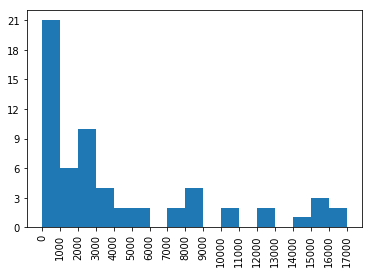

In [29]:
image_count_hist = plt.hist(image_count_per_label,
                            bins=range(0, 18000, 1000))
xt = plt.xticks(range(0, 18000, 1000), rotation=90)
yt = plt.yticks(range(0, 22, 3))

Each label is on more than 5000 images on average, with large disparities, as depicted by the previous histogram. A wide range of label are rare, with less than 1000 appearances over 18000 images.

In [30]:
print("Number of labels per image:\n{}".format(label_count_per_image.describe().astype(int)))

Number of labels per image:
count    18000
mean        18
std          4
min          2
25%         16
50%         19
75%         21
max         33
dtype: int64


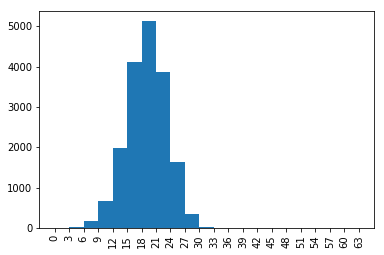

In [31]:
label_count_hist = plt.hist(label_count_per_image,
                            bins=range(0, 66, 3))
xt = plt.xticks(range(0, 66, 3), rotation=90)

On the other hand, the images show a balanced distribution regarding the number of labels they contained. It seems to follow a Gaussian distribution, with 18 labels per image on average, and 4 labels of standard deviation.

Regarding the number of images per label, we can see that 21 objects (almost a third) are represented less than 1000 times. It may be a problem for the trained model to detect them, as they are rare. Others labels are well spread regarding the number of example images; although we have to note that some label are almost always present on the images. The ideal situation would have been to have each label on 50% of the images within the dataset...

In [32]:
df_labels['nb_images'] = image_count_per_label

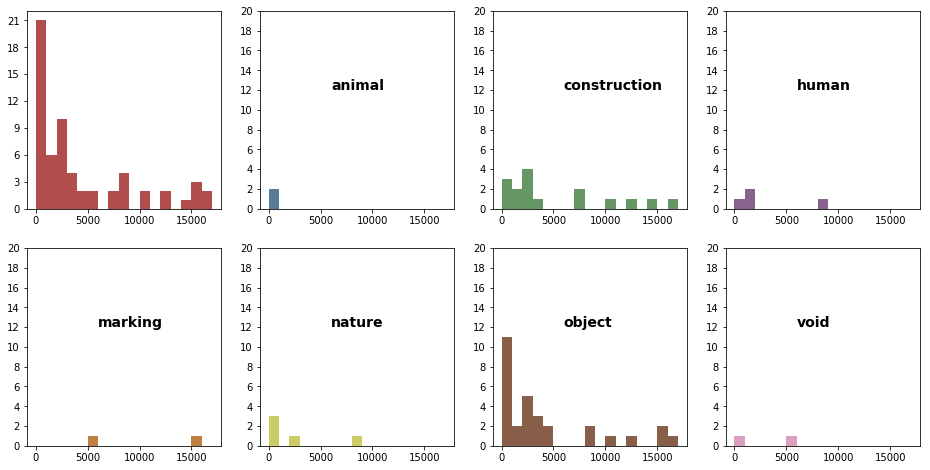

In [33]:
hist_palette = sns.color_palette("Set1", n_colors=8, desat=.5)
f, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0][0].hist(df_labels['nb_images'],
              bins=range(0, 18000, 1000),
              color=hist_palette[0])
ax[0][0].set_yticks(range(0, 22, 3))
for i, category in enumerate(df_labels['family'].unique()):
    data = df_labels.query("family==@category")['nb_images']
    ax[int((i+1)/4)][(i+1)%4].hist(data,
                                   bins=range(0, 18000, 1000),
                                   color=hist_palette[i+1])
    ax[int((i+1)/4)][(i+1)%4].set_yticks(range(0, 22, 2))
    ax[int((i+1)/4)][(i+1)%4].text(6000, 12, category, size=14, fontweight='bold')

By going into label detail, it is obvious for street-scene images to remark that almost every images contain `sky`, `road`, or `car`.

In [34]:
df_labels.sort_values("nb_images", ascending=False)[['readable', 'nb_images']].head(6)

,readable,nb_images
13,Road,17752
27,Sky,17719
45,Pole,17562
30,Vegetation,17381
55,Car,16541
17,Building,16224


On the other hand, rare objects within the dataset are mostly unusual vehicles like `caravan`, `boat` or `trailer`. It can also be unusual infrastructure like `tunnel`, or typical nature elements (`sand`) that denote a specific geographical localization.

In [35]:
df_labels.sort_values("nb_images", ascending=True)[['readable', 'nb_images']].head(6)

,readable,nb_images
56,Caravan,104
53,Boat,115
26,Sand,126
22,Other Rider,170
60,Trailer,181
18,Tunnel,201


As another interesting visualization, we can plot the number of images in which each label does appear, by highlighting object types. We then know that there are almost always `road`, `building`, `sky`, `vegetation`, `pole` or `car` labels on the pictures. Maybe these elements should be discarded from the analyse to improve the model interest. However keeping them is also a good challenge: we have to design a model able to distinguish when these object types are NOT on the image.

At the opposite, `animal`, `parking`, `tunnel` labels (and so on...) are rare objects, and the big challenge will be to detect their presence.

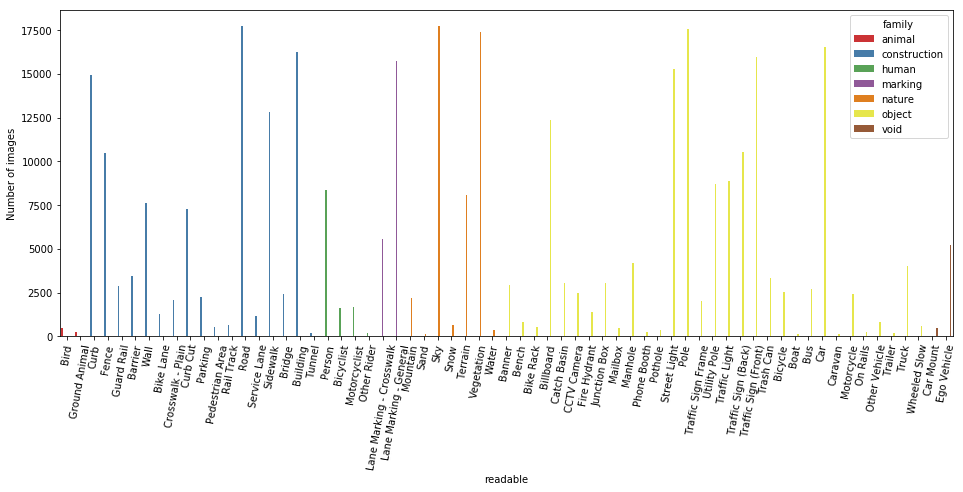

In [36]:
f = plt.figure(figsize=(16, 6))
image_per_label_plot = sns.barplot(df_labels['readable'],
                                   df_labels['nb_images'],
                                   hue=df_labels['family'],
                                   palette="Set1")
plt.ylabel("Number of images")
plt.setp(image_per_label_plot.get_xticklabels(), rotation=80)
plt.show()

## Label association

To go further into the label analysis, we can investigate on the associations between labels: which ones come always together? We use the frequent item mining framework to address this question.

In [37]:
import fim

First, we build the frequent item mining transactions, *i.e.* the list of encountered labels in each images.

In order to do this, we need to sort `label_popularity` columns:

In [91]:
label_popularity = label_popularity.T
label_popularity.index = label_popularity.index.astype(int)
label_popularity = label_popularity.sort_index().T

    17994  17995  17996  17997  17998  17999
0       0      0      0      0      0      0
1       0      0      0      1      0      0
10      0      1      0      0      1      0
11      0      0      0      0      0      0
Index(['64', '7', '8', '9'], dtype='object')
    17994  17995  17996  17997  17998  17999
0       0      0      0      0      0      0
1       0      0      0      1      0      0
10      0      1      0      0      1      0
11      0      0      0      0      0      0
Int64Index([64, 7, 8, 9], dtype='int64')
   17994  17995  17996  17997  17998  17999
0      0      0      0      0      0      0
1      0      0      0      1      0      0
2      0      1      1      1      1      1
3      1      1      0      1      0      1
Int64Index([61, 62, 63, 64], dtype='int64')
   59  60  61  62  63  64
0   0   0   0   0   0   0
1   0   0   0   0   0   0
2   0   0   0   0   0   1
3   0   0   0   0   0   0
RangeIndex(start=17996, stop=18000, step=1)


In [92]:
transactions = []
for i, lab in label_popularity.iterrows():
    transactions.append(list(itertools.compress(range(len(label_popularity)), lab==1)))

Then we compute the rules over these transactions, *i.e.* the frequent associations between different labels. The two seminal parameters are the minimal support (probability of intersect(X, Y)) and the minimal confidence (probability of Y knowing X).

In [101]:
rules = fim.arules(transactions, supp=5, conf=90, report="abhCl", eval="l", thresh=1)
rules = pd.DataFrame(rules, columns=["head", "body", "item_set_support", "body_support", "head_support", "confidence", "lift"])
rules.shape

(9143130, 7)

In [102]:
rules.head(10)

,head,body,item_set_support,body_support,head_support,confidence,lift
0,13,(),17752,18000,17752,98.622222,1.000000
1,13,"(27,)",17486,17719,17752,98.685027,1.000637
2,27,"(13,)",17486,17752,17719,98.501577,1.000637
3,27,(),17719,18000,17719,98.438889,1.000000
4,13,"(45,)",17348,17562,17752,98.781460,1.001615
5,45,"(13,)",17348,17752,17562,97.724200,1.001615
6,13,"(45, 27)",17106,17307,17752,98.838620,1.002194
7,27,"(45, 13)",17106,17348,17719,98.605027,1.001688
8,45,"(27, 13)",17106,17486,17562,97.826833,1.002667
9,27,"(45,)",17307,17562,17719,98.548001,1.001108


It seems that most important rules come from most popular labels (that's make sense!), *i.e.* `road` (13), `sky` (27) or `pole` (45). But it can be more interesting to sort these rules considering the lift (how many times the probability of Y is bigger when X is on the picture?):

In [106]:
sorted_rules = rules.sort_values('lift', ascending=False)
sorted_rules.head(5)

,head,body,item_set_support,body_support,head_support,confidence,lift
9105591,57,"(21, 19, 35, 55, 30)",857,910,2390,94.175824,7.092740
9105585,57,"(21, 19, 35, 55, 30, 13)",855,908,2390,94.162996,7.091774
9105577,57,"(21, 19, 35, 30)",871,925,2390,94.162162,7.091711
9105587,57,"(21, 19, 35, 55, 30, 27)",853,906,2390,94.150110,7.090803
9105590,57,"(21, 19, 35, 55, 30, 45)",852,905,2390,94.143646,7.090316


We then can conclude that label n°57 (`motorcycle`) is very sensitive to the apparition of other labels, like label 21 (`motorcyclist`, you bet!), 19 (`person`), 35 (`billboard`) or 30 (`vegetation`).

In [107]:
sorted_rules.groupby('head').first()

,body,item_set_support,body_support,head_support,confidence,lift
head,,,,,,
2,"(6, 9, 3, 49, 15, 44, 50)",1476,1476,14914,100.000000,1.206920
13,"(6, 9, 47, 3, 15, 24, 17, 55, 30, 27)",1172,1172,17752,100.000000,1.013970
15,"(41, 9, 48, 49, 35, 44, 55, 30, 45, 13)",905,909,12823,99.559956,1.397551
17,"(51, 19, 48, 35, 2, 24, 55, 30, 27, 13)",1232,1232,16224,100.000000,1.109467
24,"(14,)",1145,1145,15755,100.000000,1.142494
27,"(32, 6, 2, 50, 17, 55, 30, 45, 13)",1057,1057,17719,100.000000,1.015859
30,"(29, 47, 48, 3, 35, 2, 44, 24, 50, 45, 13)",950,950,17381,100.000000,1.035614
35,"(32, 9, 19, 24, 50, 55)",857,900,12334,95.222222,1.389655
44,"(54, 19, 48, 35, 15, 50, 30, 45, 27, 13)",941,953,15301,98.740818,1.161581


By considering the most strong rule for each label, we can see that `bicycle` (20) are more probable when they are `bicyclists` (52) (wow, nice algorithm...!). The other rules seems less interesting, as the lift values are smaller (less than 1.3, that means that the probability of having the considered labels is at most 30% larger if the set of explaining labels are gathered).

Finally, we can end this analysis by determining the number of rules for each labels. We understand that the rules that correspond to the support and confidence criteria are focused on most popular labels.

In [117]:
df_labels['nb_rules'] = [len(rules.query("head==@i")) for i in range(df_labels.shape[0])]
df_labels.loc[df_labels['nb_rules']>0, ["readable", "nb_rules"]]

,readable,nb_rules
2,Curb,809205
13,Road,831008
15,Sidewalk,657441
17,Building,835609
24,Lane Marking - General,843151
27,Sky,836511
30,Vegetation,844804
35,Billboard,63564
44,Street Light,847374
45,Pole,831789
